# Task 2
We are provided with 100 images, accompanied with a csv file containing information about each object in the image. Each image has a varying number of objects, and hence there are a varying number of vectors (csv rows), so each image is represented by a varying number of feature vectors. 

A common approach to overcome this problem is to use Bag of Words (BoW). This method is used for example to find similar images in a dataset (known as Visual Bag of Words - VBoW). In our dataset we can separate each image into two sets: the ego vehicle, and the feature vector of the detections in the image. The ego vehicle is represented by single vector. It is the number of detections that vary. So BoW will be used on the feature vectors of detections in all images.

The method works as follows:
1. All detections feature vectors, of all images is our corpus. We cluster the corpus into k clusters. Each cluster is represented by a centroid (a word)
2. Each detection feature vector is assigned to the cluster with the closest centroid.
3. Each image is then represented by a histogram of the clusters appearing in the image. The histogram is normalized, and each word is weighted by its inverse appearance frequency (also known as inverse document frequency - IDF).
4. This histogram is the BoW representation of the image.

The embeddings used for clustering the feature vectors is important. We will use an autoencoder to learn the embeddings. 

At the end of this process, each image will be represented by a single vector. The first part is BoW describing the detections in the image. The second part is the feature vector of the ego vehicle. The two parts will be concatenated to form the final representation of the image.


## Data Preprocessing

In [1]:
import sklearn
import numpy as np
import csv
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib widget

with open('../data.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    data = list(reader)

data = np.array(data[1:]) # remove header
# collect unique image ids
image_ids, csv_indices = np.unique(data[:,0], return_index=True) # get unique image ids and their indices

ego_vectors = data[csv_indices, -6:].astype(np.float32)
image_index_to_id = {i: image_id for i, image_id in enumerate(image_ids)} # mapper from image index to image id
print('ego_vectors.shape:', ego_vectors.shape)

# read the corpus of object detections
# --------------------------------
detections_vectors = data[:, 2:8].astype(np.float32)
print('object_vectors.shape:', detections_vectors.shape)

ego_vectors.shape: (100, 6)
object_vectors.shape: (840, 6)


## Autoencoder
The autoencoder is used to learn the embeddings of the feature vectors. The input is the feature vector, and the output is the same vector. The idea is to learn useful embeddings of the feature vectors.

In [2]:
import torch
import torch.nn as nn

torch.manual_seed(0)

# PARAMETERS
LATENT_DIM = 2  # number of autoencoder latent dimensions

# Define the autoencoder class
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 3),
            nn.ReLU(),
            nn.Linear(3, latent_dim),
        )
        
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 3),
            nn.ReLU(),
            nn.Linear(3, input_dim),
        )
    
        # initialize the weights
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.5)

    def forward(self, x):
        # Encode the input
        encoded = self.encoder(x)
        
        # Decode the encoded input
        decoded = self.decoder(encoded)
        
        return encoded, decoded

# Create an instance of the autoencoder
input_dim = detections_vectors.shape[1]  # Input dimension
latent_dim = LATENT_DIM  # Latent dimension

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

autoencoder = Autoencoder(input_dim, latent_dim)
autoencoder.to(device)
# Print the autoencoder architecture
print(autoencoder)


Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=6, out_features=3, bias=True)
    (1): ReLU()
    (2): Linear(in_features=3, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=3, bias=True)
    (1): ReLU()
    (2): Linear(in_features=3, out_features=6, bias=True)
  )
)


## Training the Autoencoder For Detection Embeddings


model saved
Epoch [1/300], Loss: 1318.3057
model saved
Epoch [2/300], Loss: 387.7114
model saved
Epoch [3/300], Loss: 352.0787
Epoch [4/300], Loss: 499.7513
Epoch [5/300], Loss: 465.8799
Epoch [6/300], Loss: 1110.2635
model saved
Epoch [7/300], Loss: 118.7885
model saved
Epoch [8/300], Loss: 6.8201
model saved
Epoch [9/300], Loss: 4.2065
Epoch [10/300], Loss: 8.4245
Epoch [11/300], Loss: 7.4915
Epoch [12/300], Loss: 7.6889
model saved
Epoch [13/300], Loss: 4.0552
Epoch [14/300], Loss: 7.1715
model saved
Epoch [15/300], Loss: 2.9119
model saved
Epoch [16/300], Loss: 1.8843
Epoch [17/300], Loss: 4.6672
Epoch [18/300], Loss: 1.8891
Epoch [19/300], Loss: 2.0753
Epoch [20/300], Loss: 3.0056
Epoch [21/300], Loss: 2.6256
model saved
Epoch [22/300], Loss: 1.3550
Epoch [23/300], Loss: 4.4205
Epoch [24/300], Loss: 3.1767
Epoch [25/300], Loss: 2.1980
Epoch [26/300], Loss: 3.6955
Epoch [27/300], Loss: 3.7390
Epoch [28/300], Loss: 2.2170
Epoch [29/300], Loss: 1.5703
model saved
Epoch [30/300], Loss

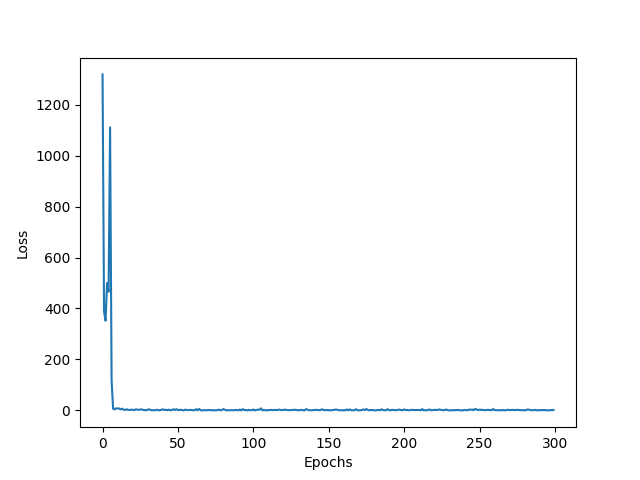

best epoch: 66, best loss: 0.20702219009399414


In [3]:
import torch.optim as optim

EPOCHS = 300   # number of training epochs
BATCH_SIZE = 2 # number of training samples per batch

autoencoder = Autoencoder(input_dim, latent_dim)
autoencoder.to(device)

detection_tensors = torch.from_numpy(detections_vectors).to(device)
detection_tensors = detection_tensors.type(torch.FloatTensor)

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(autoencoder.parameters(), lr=1E-3) #1E-4
# add a learning rate scheduler
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# Train the autoencoder
num_epochs = EPOCHS
batch_size = BATCH_SIZE

loss_recorder= []
min_loss = 1000000
for epoch in range(num_epochs):
    # Shuffle the data
    indices = torch.randperm(detection_tensors.size(0))
    shuffled_detection_tensors = detection_tensors[indices]
    
    # Split the data into batches
    num_batches = len(shuffled_detection_tensors) // batch_size
    for i in range(num_batches):
        # Get a batch of data
        batch = shuffled_detection_tensors[i * batch_size: (i + 1) * batch_size]
        
        # Move the batch to CUDA if available
        batch = batch.to(device)
        
        
        # Forward pass
        _, output = autoencoder(batch)
        
        # Compute the loss
        loss = criterion(output, batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # save best weights
    if loss.item() < min_loss:
        min_loss = loss.item()
        torch.save(autoencoder.state_dict(), 'best_model_task2.pth')
        print('model saved')
        best_epoch = epoch    
    # Decay the learning rate
    # scheduler.step()

    # add loss
    loss_recorder.append(loss.item())
    
    # Print the loss for every epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")#, Learning rate: {scheduler.get_lr()[0]:.8f}")

# Plot the loss
plt.plot(loss_recorder)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

print(f"best epoch: {best_epoch}, best loss: {min_loss}" )


## Run K-Means on the Latent Space
Now, lets pass the BoW representing each image and get the latent space representation. We will then run K-Means on the latent space, and use cosine similarity to classify the images.

Text(0.5, 1.0, 'Object detections latent space')

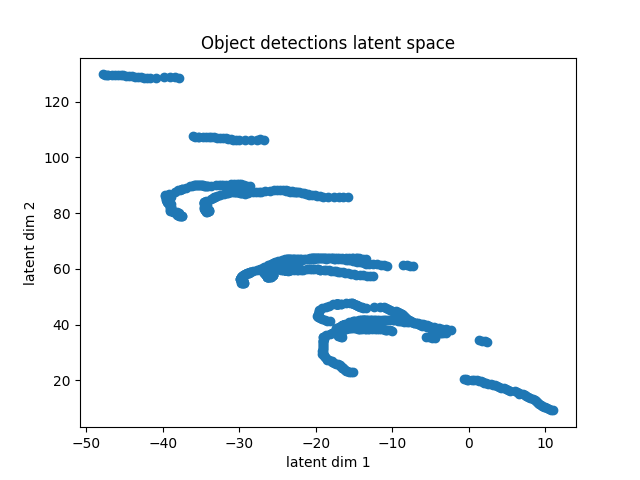

In [4]:
# Load the best model
autoencoder.load_state_dict(torch.load('best_model_task2.pth'))
autoencoder.to(device)
# use for inference
autoencoder.eval()

# Encode the data
encoded_data, _ = autoencoder(detection_tensors.to(device))
encoded_data = encoded_data.detach().cpu().numpy()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(encoded_data[:,0], encoded_data[:,1], marker='o')
ax.set_xlabel('latent dim 1')
ax.set_ylabel('latent dim 2')
plt.title('Object detections latent space')



Looking at the latent space, we can see that the detections can be clustered into 6 clusters. We will use this number of clusters for K-Means.

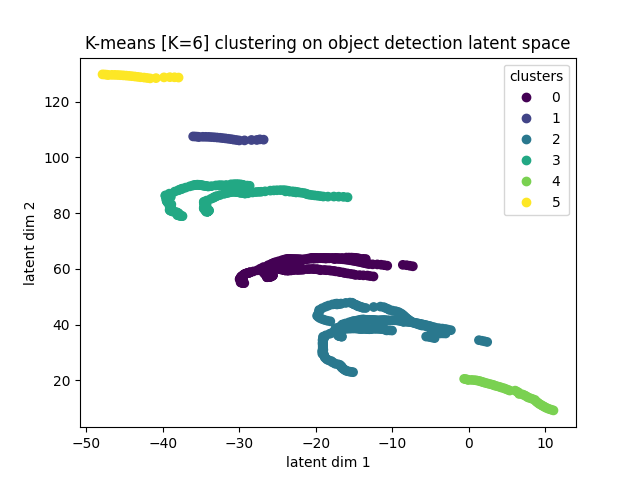

In [5]:
# Run k-means on the encoded data
N_CLUSTERS = 6
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(encoded_data)

# Plot the encoded data
fig = plt.figure()
ax = fig.add_subplot(111)
sc = ax.scatter(encoded_data[:,0], encoded_data[:,1], c=kmeans.labels_, marker='o')
ax.legend(*sc.legend_elements(), title='clusters')
ax.set_xlabel('latent dim 1')
ax.set_ylabel('latent dim 2')
plt.title('K-means [K=6] clustering on object detection latent space')
plt.show()

## BoW representation of objects
Now that we have an embedding for each object in each image, we can use BoW to represent each image. 

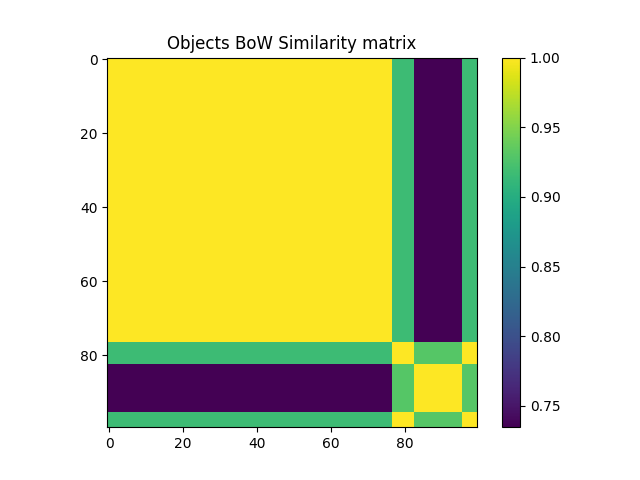

In [6]:
from sklearn.metrics.pairwise import cosine_similarity

# classify each object to its cluster using the above kmeans and autoencoder
# -------------------------------------------------------------------------
# get the cluster of each object
words = kmeans.predict(encoded_data)

# calculate the tf-idf weights
# ----------------------------
# calculate the frequency of each word
word_freq = np.zeros(N_CLUSTERS)
for word in words:
    word_freq[word] += 1

# calculate the number of images containing each word (on log scale)
idf = np.log(len(image_ids) / 1 + word_freq)

# calculate the tf-idf weights
image_id_to_index = {v: k for k, v in image_index_to_id.items()}
detections_BoW = np.zeros((len(image_ids), N_CLUSTERS))
for image_id, word in zip(data[:,0], words):
    detections_BoW[image_id_to_index[image_id], word] += 1
detections_BoW *= idf

detections_BoW = sklearn.preprocessing.normalize(detections_BoW, norm='l2', axis=1)

similarity_matrix = cosine_similarity(detections_BoW[:, :6])

# plot the similarity matrix
plt.figure()
plt.imshow(similarity_matrix)
plt.colorbar()
plt.title('Objects BoW Similarity matrix')
plt.show()




Now lets create a single vector for every image, using the ego car information and the BoW representation of the objects in the image.

In [7]:
# create a single vector for each image
# -------------------------------------
images_vectors= np.concatenate((detections_BoW, ego_vectors), axis=1)

# Clustering the Images With Scene Embedding and Ego Vehicle Information
Now that we have a single vector for each image, we can cluster the images again using an autoencoder. 

model saved
Epoch [1/1000], Loss: 10.0219
model saved
Epoch [2/1000], Loss: 4.8664
Epoch [3/1000], Loss: 9.9194
Epoch [4/1000], Loss: 5.6745
Epoch [5/1000], Loss: 9.0307
Epoch [6/1000], Loss: 5.4748
Epoch [7/1000], Loss: 8.7497
Epoch [8/1000], Loss: 6.1230
Epoch [9/1000], Loss: 5.1849
Epoch [10/1000], Loss: 6.4622
Epoch [11/1000], Loss: 13.0617
Epoch [12/1000], Loss: 11.7140
model saved
Epoch [13/1000], Loss: 2.1609
Epoch [14/1000], Loss: 11.5995
Epoch [15/1000], Loss: 6.2379
Epoch [16/1000], Loss: 4.9543
Epoch [17/1000], Loss: 4.7439
Epoch [18/1000], Loss: 4.1860
Epoch [19/1000], Loss: 6.7664
Epoch [20/1000], Loss: 2.6328
Epoch [21/1000], Loss: 7.5751
Epoch [22/1000], Loss: 10.0917
Epoch [23/1000], Loss: 9.1845
model saved
Epoch [24/1000], Loss: 1.3796
Epoch [25/1000], Loss: 3.6739
Epoch [26/1000], Loss: 6.0552
Epoch [27/1000], Loss: 5.5781
Epoch [28/1000], Loss: 6.3522
Epoch [29/1000], Loss: 4.1771
Epoch [30/1000], Loss: 3.0582
Epoch [31/1000], Loss: 2.7148
Epoch [32/1000], Loss: 11.

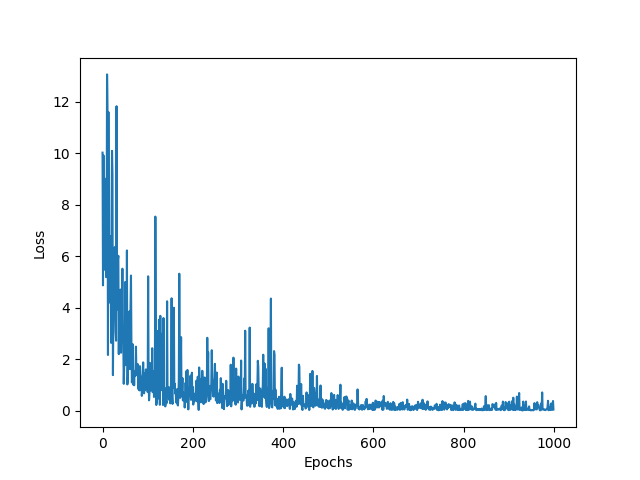

best epoch: 931, best loss: 0.008161241188645363


In [8]:

autoencoder = Autoencoder(images_vectors.shape[1], latent_dim)
autoencoder.to(device)

image_tensors = torch.from_numpy(images_vectors).to(device)
image_tensors = image_tensors.type(torch.FloatTensor)

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(autoencoder.parameters(), lr=1E-4) #1E-4
# add a learning rate scheduler
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# Train the autoencoder
num_epochs = 1000
batch_size = BATCH_SIZE

loss_recorder= []
min_loss = 1000000
for epoch in range(num_epochs):
    # Shuffle the data
    indices = torch.randperm(image_tensors.size(0))
    shuffled_image_tensors = image_tensors[indices]
    
    # Split the data into batches
    num_batches = len(shuffled_image_tensors) // batch_size
    for i in range(num_batches):
        # Get a batch of data
        batch = shuffled_image_tensors[i * batch_size: (i + 1) * batch_size]
        
        # Move the batch to CUDA if available
        batch = batch.to(device)
        
        
        # Forward pass
        _, output = autoencoder(batch)
        
        # Compute the loss
        loss = criterion(output, batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # save best weights
    if loss.item() < min_loss:
        min_loss = loss.item()
        torch.save(autoencoder.state_dict(), 'best_model_task2_2.pth')
        print('model saved')
        best_epoch = epoch    
    # Decay the learning rate
    # scheduler.step()

    # add loss
    loss_recorder.append(loss.item())
    
    # Print the loss for every epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")#, Learning rate: {scheduler.get_lr()[0]:.8f}")

# Plot the loss
plt.figure()
plt.plot(loss_recorder)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

print(f"best epoch: {best_epoch}, best loss: {min_loss}" )


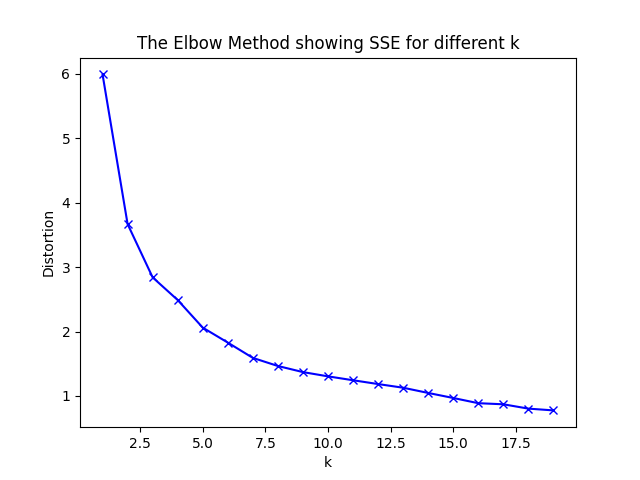

In [9]:
from scipy.spatial.distance import cdist

# Load the best model
autoencoder.load_state_dict(torch.load('best_model_task2_2.pth'))
autoencoder.to(device)
# use for inference
autoencoder.eval()

# Encode the data
encoded_data, _ = autoencoder(image_tensors.to(device))
encoded_data = encoded_data.detach().cpu().numpy()


# calculate optimal number of clusters with the elbow method
# ---------------------------------------------------------
# k means determine k
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(encoded_data)
    kmeanModel.fit(encoded_data)
    distortions.append(sum(np.min(cdist(encoded_data, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / encoded_data.shape[0])

# Plot the elbow
plt.figure()
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing SSE for different k')
plt.show()


Using the elbow method, we can see that the optimal number of clusters is 4. We will use this number of clusters for K-Means.

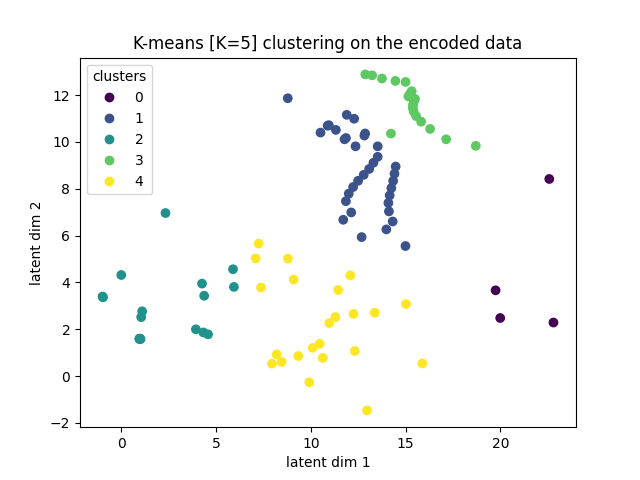

In [10]:

# Run k-means on the encoded data
N_CLUSTERS = 5
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(encoded_data)

# Plot the encoded data
fig = plt.figure()
ax = fig.add_subplot(111)
sc = ax.scatter(encoded_data[:,0], encoded_data[:,1], c=kmeans.labels_, marker='o')
ax.legend(*sc.legend_elements(), title='clusters')
ax.set_xlabel('latent dim 1')
ax.set_ylabel('latent dim 2')
plt.title(f'K-means [K={N_CLUSTERS}] clustering on the encoded data')
plt.show()




### Store the images according to their clusters
Each image will be stored under `/clusters/k_i` where k_i is the cluster number the image belongs to.

In [11]:
import os
import shutil
os.makedirs('clusters', exist_ok=True)

data_path = "/DATA/Autobrains/EON/Images/"
# find the cluster of each image and copy it to a folder
for image_id, cluster in enumerate(kmeans.labels_):
    cluster = int(cluster)   
    image_path = image_index_to_id[image_id] + ".png"
    if os.path.exists(data_path + image_path):
        os.makedirs(f'clusters/{cluster}', exist_ok=True)
        shutil.copy(data_path + image_path, f'clusters/{cluster}/'+image_path)

    else: 
        print(f'Image {data_path + image_path} not found')
        
        

# Output Clusters:
Below are the image sequences of each cluster. I tried to interpret the clusters semantically. I couldn't do it for all clusters.

Cluster 1 - ego vehicle travels in a straight line (except for the last few images where lane change is just initiated)

<img src="1.gif" width="400">

Cluster 2 - ego vehicle is accelerating (drive initiated)

<img src="2.gif" width="400">

Cluster 4 - ego vehicle is accelerating (drive initiated)

<img src="4.gif" width="400">

Cluster 3 - ego vehicle is changing lane

<img src="3.gif" width="400">


Cluster 0 - This is a small cluster, the data is inconclusive.

<img src="0.gif" width="400">